## Import necessary libraries and set the starting parameters

In [1]:
import os
import xarray as xr
import numpy as np
from datetime import datetime, timedelta
from parcels import (Field, FieldSet, ParticleSet, JITParticle,
                     AdvectionRK4, ErrorCode, Variable)
from glob import glob
from scipy.ndimage import distance_transform_edt
import matplotlib as plt
import matplotlib.pyplot as plt
from tqdm import tqdm
import cmasher as cmr
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors
import cmocean

### PARAMETERS ###
particles_per_cell = 7

latiMin = 0
latiMax = -23.5
longMin = 35
longMax = 77.5

# Start Time
t0 = datetime(year=1993, month=1, day=1, hour=12)

# Duration, calculation timestep, output interval
run_time = timedelta(weeks = 52)
run_dt = timedelta(minutes = 15)
output_dt = timedelta(weeks = 26)

# Sinking and Beaching timescales
ts = 1/timedelta(days=365).total_seconds() # Decay timescale
tb = 1/timedelta(days = 30).total_seconds()

### DIRECTORIES ###
dirs = {}
dirs['root'] = os.getcwd() + '/../../'
dirs['script'] = dirs['root'] + 'ocean_personal_data/albinski/'
dirs['traj'] = dirs['root'] + 'ocean_personal_data/albinski/TrajectoriesWithSubS/'
dirs['ocean'] = dirs['root'] + 'snapdragon/swio/WINDS-M/'
dirs['grid'] = dirs['root'] + 'ocean_personal_data/albinski/'

#Automation of file name creation
start_year_month = f"{t0.year}_{t0.month:02d}"
duration_weeks = int(run_time.days / 7)
coordinates_for_file = f"{abs(latiMin)}{abs(latiMax)}{longMin}{longMax}" 
traj_filename = f"{start_year_month}_{duration_weeks}w_{coordinates_for_file}_{particles_per_cell}rho.zarr"

# File handles
fh = {}
fh['ocean'] = sorted(glob(dirs['ocean'] + 'WINDS_SFC_199*.nc'))
fh['grid'] = dirs['grid'] + 'croco_grd.nc'
fh['traj'] = dirs['traj'] + traj_filename

ds = xr.open_dataset('/home/ocean_personal_data/albinski/croco_grd.nc')
bounds = {'lon0': longMin, 'lon1': longMax, 'lat0': latiMax, 'lat1': latiMin}

In [ ]:
winds = xr.open_dataset('/home/ocean_personal_data/albinski/WINDS_SFC_199502.nc')
winds

In [ ]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt

file_path = '/home/ocean_personal_data/albinski/WINDS_SFC_199502.nc'

with Dataset(file_path, 'r') as nc:
    u_surf = nc.variables['u_surf'][10]  
    v_surf = nc.variables['v_surf'][10]  

    if u_surf.shape[1:] != v_surf.shape[1:]:
        raise ValueError("Spatial dimensions of u_surf and v_surf do not match")

speed = np.sqrt(u_surf**2 + v_surf**2)

average_speed = np.mean(speed, axis=0)

if average_speed.ndim != 2:
    raise ValueError("average_speed is not 2-dimensional")

plt.figure(figsize=(10, 6))
plt.pcolormesh(average_speed, cmap='jet') 
plt.colorbar(label='Average Surface Current Speed (m/s)')
plt.title('Average Surface Current Speed for the Month')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.show()



In [15]:
average_array_nanmean = np.load('/home/ocean_personal_data/albinski/emilia/sum_all_deployments.npy')

lon_psi = ds['lon_psi'].values[:-1, :-1]
lat_psi = ds['lat_psi'].values[:-1, :-1]

threshold_mask = average_array_nanmean > 0

lon_psi_masked = np.where(threshold_mask, lon_psi, np.nan)
lat_psi_masked = np.where(threshold_mask, lat_psi, np.nan)

dlon = np.diff(lon_psi_masked, axis=1, append=lon_psi_masked[:, -1:])
dlat = np.diff(lat_psi_masked, axis=0, append=lat_psi_masked[-1:, :])

lon_starts = lon_psi_masked[:, :, np.newaxis]
lat_starts = lat_psi_masked[:, :, np.newaxis]
lon_quarters = lon_starts + np.linspace(0, 1, particles_per_cell + 1)[:-1] * dlon[:, :, np.newaxis] + dlon[:, :, np.newaxis] / particles_per_cell / 2
lat_quarters = lat_starts + np.linspace(0, 1, particles_per_cell + 1)[:-1] * dlat[:, :, np.newaxis] + dlat[:, :, np.newaxis] / particles_per_cell / 2

flat_lon_quarters = lon_quarters.reshape(-1)
flat_lat_quarters = lat_quarters.reshape(-1)
valid_positions = ~np.isnan(flat_lon_quarters) & ~np.isnan(flat_lat_quarters)

particle_lon = flat_lon_quarters[valid_positions]
particle_lat = flat_lat_quarters[valid_positions]

np.save('/home/ocean_personal_data/albinski/emilia/dfad_particle_lats.npy',particle_lat)
np.save('/home/ocean_personal_data/albinski/emilia/dfad_particle_lons.npy', particle_lon)

print(len(particle_lat))

8863575


In [ ]:
particle_lat1 = np.load('/home/ocean_personal_data/albinski/pre_work_for_RUNS/particle_seeding_lat_lon/particle_lat_around_land.npy')
particle_lon1 = np.load('/home/ocean_personal_data/albinski/pre_work_for_RUNS/particle_seeding_lat_lon/particle_lon_around_land.npy')

particle_lat2 = np.load('/home/ocean_personal_data/albinski/pre_work_for_RUNS/pre_scripts/all_ships_greater_0_lat.npy')
particle_lon2 = np.load('/home/ocean_personal_data/albinski/pre_work_for_RUNS/pre_scripts/all_ships_greater_0_lon.npy')

combined_lat = np.concatenate((particle_lat1, particle_lat2))
combined_lon = np.concatenate((particle_lon1, particle_lon2))

np.save('/home/ocean_personal_data/albinski/combined_lat_tho.npy', combined_lat)
np.save('/home/ocean_personal_data/albinski/combined_lon_tho.npy', combined_lon)

In [ ]:
lon_psi = ds['lon_psi'].values
lat_psi = ds['lat_psi'].values

dlon = np.diff(lon_psi, axis=1)
dlat = np.diff(lat_psi, axis=0)
dlon = np.hstack([dlon, dlon[:, -1:]])
dlat = np.vstack([dlat, dlat[-1:, :]])

# Vectorize the calculation of particle positions within each grid cell
lon_starts = lon_psi[:, :, np.newaxis]
lat_starts = lat_psi[:, :, np.newaxis]
lon_quarters = lon_starts + np.linspace(0, 1, particles_per_cell + 1)[:-1] * dlon[:, :, np.newaxis] + dlon[:, :, np.newaxis] / particles_per_cell / 2
lat_quarters = lat_starts + np.linspace(0, 1, particles_per_cell + 1)[:-1] * dlat[:, :, np.newaxis] + dlat[:, :, np.newaxis] / particles_per_cell / 2

# Flatten the arrays
flat_lon_quarters = lon_quarters.reshape(-1)
flat_lat_quarters = lat_quarters.reshape(-1)

# Create a mask to filter out nan values
valid_positions = ~np.isnan(flat_lon_quarters) & ~np.isnan(flat_lat_quarters)

# Apply mask to get final particle positions
particle_lon = flat_lon_quarters[valid_positions]
particle_lat = flat_lat_quarters[valid_positions]
print(np.amax(particle_lat))
print(np.amin(particle_lat))
np.save('whole_grid_lat.npy', particle_lat)
np.save('whole_grid_lon.npy', particle_lon)

In [5]:
# Particles removed where there are land cells
lon_psi = ds['lon_psi'].values
lat_psi = ds['lat_psi'].values
mask_psi = ds['mask_psi'].values

in_bounds = (lon_psi >= 71.5) & (lon_psi <= 75) & \
            (lat_psi >= -4.5) & (lat_psi <= 0)

lon_psi_masked = np.where(in_bounds, lon_psi,np.nan)
lat_psi_masked = np.where(in_bounds, lat_psi,np.nan)

particles_per_cell = 12

dlon = np.diff(lon_psi_masked, axis=1)
dlat = np.diff(lat_psi_masked, axis=0)
dlon = np.hstack([dlon, dlon[:, -1:]])
dlat = np.vstack([dlat, dlat[-1:, :]])

lon_starts = lon_psi_masked[:, :, np.newaxis]
lat_starts = lat_psi_masked[:, :, np.newaxis]
lon_quarters = lon_starts + np.linspace(0, 1, particles_per_cell + 1)[:-1] * dlon[:, :, np.newaxis] + dlon[:, :, np.newaxis] / particles_per_cell / 2
lat_quarters = lat_starts + np.linspace(0, 1, particles_per_cell + 1)[:-1] * dlat[:, :, np.newaxis] + dlat[:, :, np.newaxis] / particles_per_cell / 2

flat_lon_quarters = lon_quarters.reshape(-1)
flat_lat_quarters = lat_quarters.reshape(-1)

mask_psi_repeated = np.repeat(mask_psi[:, :, np.newaxis], particles_per_cell, axis=2)
flat_mask_psi_repeated = mask_psi_repeated.reshape(-1)
valid_grid_cells = flat_mask_psi_repeated == 1

particle_lon = flat_lon_quarters[valid_grid_cells]
particle_lat = flat_lat_quarters[valid_grid_cells]

#particle_lat = particle_lat[~np.isnan(particle_lat)]
#particle_lon = particle_lon[~np.isnan(particle_lon)]

np.save('validation_particle_lat.npy', particle_lat)
np.save('validation_particle_lon.npy', particle_lon)
print(np.nanmax(particle_lat))
print(np.nanmin(particle_lat))
print(np.nanmax(particle_lon))
print(np.nanmin(particle_lon))
print(len(particle_lat))
print(len(particle_lon))

-0.019720717026370196
-4.493409966788378
74.98916666666668
71.51083333333332
26507724
26507724


In [6]:
not_nan_indices = ~(np.isnan(particle_lat) | np.isnan(particle_lon))

# Filter both arrays to keep only values at these indices
filtered_array1 = particle_lon[not_nan_indices]
filtered_array2 = particle_lat[not_nan_indices]

print(len(filtered_array1))

np.save('validation_particle_lat.npy', filtered_array2)
np.save('validation_particle_lon.npy', filtered_array1)

467268


In [ ]:
import numpy as np

lon_psi = ds['lon_psi'].values
lat_psi = ds['lat_psi'].values
mask_psi = ds['mask_psi'].values

particles_per_cell = 12

dlon = np.diff(lon_psi, axis=1)
dlat = np.diff(lat_psi, axis=0)
dlon = np.hstack([dlon, dlon[:, -1:]])
dlat = np.vstack([dlat, dlat[-1:, :]])

lon_starts = lon_psi[:, :, np.newaxis]
lat_starts = lat_psi[:, :, np.newaxis]
lon_quarters = lon_starts + np.linspace(0, 1, particles_per_cell + 1)[:-1] * dlon[:, :, np.newaxis] + dlon[:, :, np.newaxis] / particles_per_cell / 2
lat_quarters = lat_starts + np.linspace(0, 1, particles_per_cell + 1)[:-1] * dlat[:, :, np.newaxis] + dlat[:, :, np.newaxis] / particles_per_cell / 2

flat_lon_quarters = lon_quarters.reshape(-1)
flat_lat_quarters = lat_quarters.reshape(-1)

edge_mask = np.zeros_like(mask_psi, dtype=bool)
edge_mask[:4, :] = True
edge_mask[-4:, :] = True
edge_mask[:, :4] = True
edge_mask[:, -4:] = True

combined_mask = np.logical_and(mask_psi == 1, edge_mask)

mask_psi_repeated = np.repeat(combined_mask[:, :, np.newaxis], particles_per_cell, axis=2)
flat_mask_psi_repeated = mask_psi_repeated.reshape(-1)
valid_grid_cells = flat_mask_psi_repeated

particle_lon = flat_lon_quarters[valid_grid_cells]
particle_lat = flat_lat_quarters[valid_grid_cells]

np.save('/home/ocean_personal_data/albinski/edges_lat.npy', particle_lat)
np.save('/home/ocean_personal_data/albinski/edges_lon.npy', particle_lon)

print(len(particle_lat))


In [13]:
particle_lat1 = np.load('/home/ocean_personal_data/albinski/pre_work_for_RUNS/pre_scripts/validation_particle_lat_1.npy')
particle_lon1 = np.load('/home/ocean_personal_data/albinski/pre_work_for_RUNS/pre_scripts/validation_particle_lon_1.npy')

particle_lat2 = np.load('/home/ocean_personal_data/albinski/pre_work_for_RUNS/pre_scripts/validation_particle_lat_2.npy')
particle_lon2 = np.load('/home/ocean_personal_data/albinski/pre_work_for_RUNS/pre_scripts/validation_particle_lon_2.npy')

print(np.nanmax(particle_lon2))
print(np.nanmin(particle_lon2))

combined_lat = np.concatenate((particle_lat1, particle_lat2))
combined_lon = np.concatenate((particle_lon1, particle_lon2))

np.save('validation_particle_lat.npy', combined_lat)
np.save('validation_particle_lon.npy', combined_lon)

71.68900000000001
70.951


In [22]:
data = xr.open_dataset('/home/ocean_personal_data/albinski/RUNS_Trajs/1993_04_78w_s1.zarr')

particle_lat = data.lat_initial
particle_lon = data.lon_initial
flat_particle_lat = particle_lat.values.flatten()
flat_particle_lon = particle_lon.values.flatten()
print(len(particle_lat))

5255620


/home/users/ug20g1/miniconda3/envs/initialenv/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/users/ug20g1/miniconda3/envs/initialenv/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'h5netcdf' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/users/ug20g1/miniconda3/envs/initialenv/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


[0. 8.]


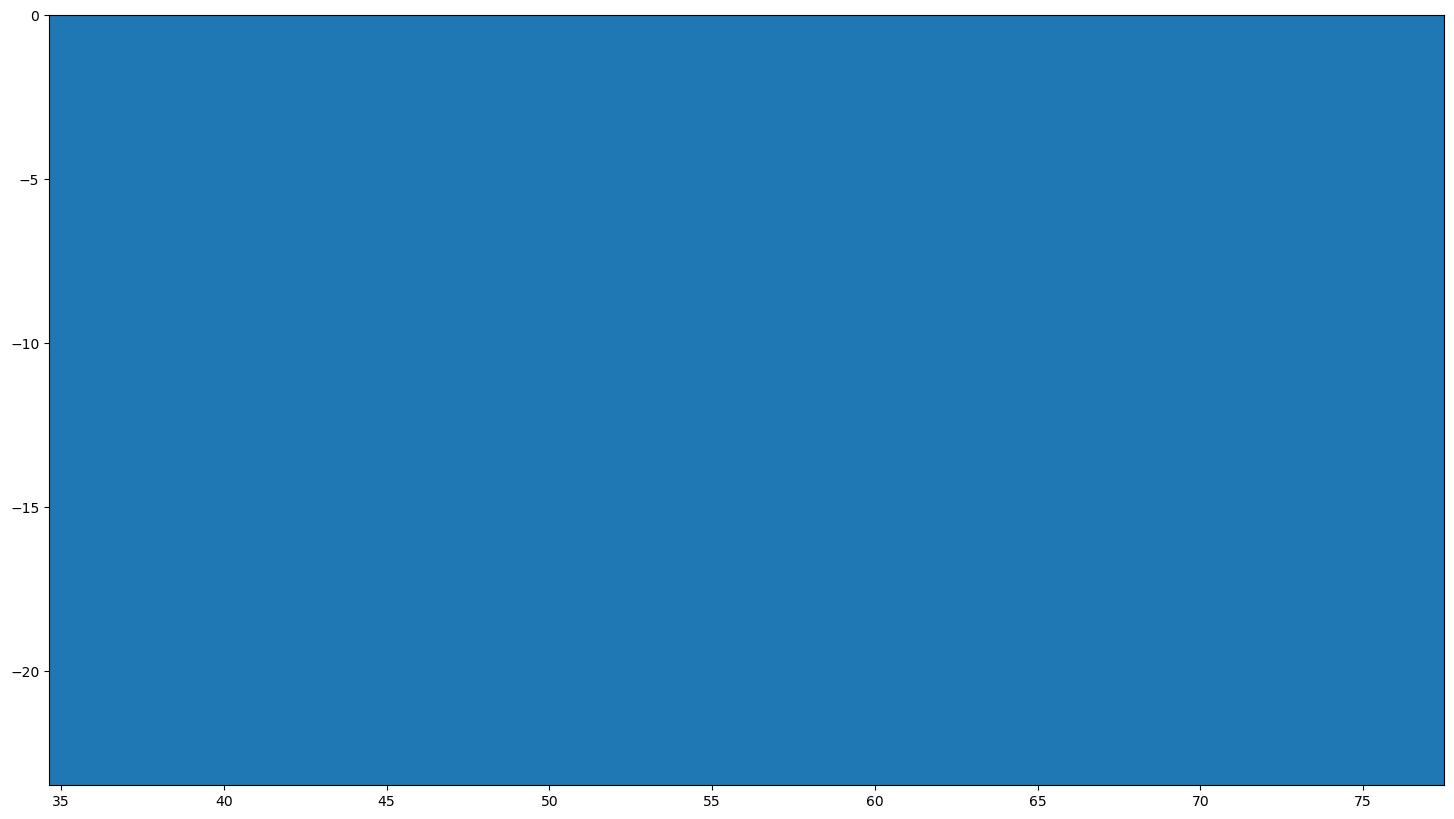

In [23]:
f, ax = plt.subplots(1, 1, figsize=(18,10))
#ax.scatter(particle_lon, particle_lat, c='r', s=0.01, marker='.')
# Plot the land masses
ax.pcolormesh(ds.lon_psi[0, :],
                     ds.lat_psi[:, 0],
                     np.ma.masked_array(np.ones_like(ds.mask_rho[1:-1, 1:-1]),
                                        mask=ds.mask_rho[1:-1, 1:-1]),
                                        cmap=cmr.neutral)

hist_count, _, _ = np.histogram2d(flat_particle_lon, flat_particle_lat ,
                                 bins=[ds.lon_psi[0, :], ds.lat_psi[:, 0]])
hist_count[hist_count>8] = 0

ax.pcolormesh(ds.lon_psi,ds.lat_psi, hist_count.T, cmap='tab20')

print(np.unique(hist_count))


In [ ]:
f, ax = plt.subplots(1, 1, figsize=(20, 10))

cmap_count = ax.pcolormesh(ds.lon_psi[0, :], 
                           ds.lat_psi[:, 0], 
                           hist_count.T, 
                           cmap='viridis')

cbar = plt.colorbar(cmap_count, ax=ax)
cbar.set_label('Particle Count')

ax.set_aspect('equal')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')


plt.show()


In [ ]:
test_data = xr.open_dataset('/home/ocean_personal_data/albinski/Trajs/1993_01_0w.zarr')

sampled_lon_initial = test_data.lon_initial[:,1]
sampled_lat_initial = test_data.lat_initial[:,1]

hist_count, _, _ = np.histogram2d(sampled_lon_initial, sampled_lat_initial ,
                                  bins=[ds.lon_psi[0, :], ds.lat_psi[:, 0]])

unique_values = np.unique(hist_count.T)
print(unique_values)

special_value = 10
special_color = (1, 0, 0, 1) 


default_color = (0.5, 0.5, 0.5, 1)
color_list = [special_color if value == special_value else default_color for value in unique_values]

cmap = mcolors.ListedColormap(color_list)
norm = mcolors.BoundaryNorm(boundaries=unique_values, ncolors=len(unique_values))

f, ax = plt.subplots(1, 1, figsize=(20, 10))
cmap_count = ax.pcolormesh(ds.lon_psi[0, :], 
                           ds.lat_psi[:, 0], 
                           hist_count.T, 
                           cmap=cmap, norm=norm)

cbar = plt.colorbar(cmap_count, ax=ax)
cbar.set_label('Particle Count')

ax.set_aspect('equal')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

In [ ]:
mask_psi = ds['mask_psi'].values
lon_psi = ds['lon_psi'].values
lat_psi = ds['lat_psi'].values

# Calculate the distance transform using mask_psi
distance_to_coast_psi = distance_transform_edt(mask_psi)  # Calculating distance from the grid cells to the land cells

clustering_labels = np.load('/home/ocean_personal_data/albinski/emilia/cluster_labels_1_degree.npy')

# Assigning the clustering labels to land points
labels_grid = np.full(mask_psi.shape, -1)
labels_grid[np.where(mask_psi == 0)] = clustering_labels

# Calculate distances and indices to nearest land
distances, indices = distance_transform_edt(mask_psi != 0, return_indices=True)
nearest_land_indices = tuple(indices[i, mask_psi != 0] for i in range(len(indices)))

ocean_labels = labels_grid[nearest_land_indices]
final_labels_grid_psi = np.full(mask_psi.shape, -1)
final_labels_grid_psi[mask_psi != 0] = ocean_labels

# Masking the placeholder values (-1) before plotting
final_labels_grid_masked_psi = np.ma.masked_where(final_labels_grid_psi == -1, final_labels_grid_psi)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

f, ax = plt.subplots(1, 1, figsize=(10, 5))

lon_grid, lat_grid = np.meshgrid(ds.lon_psi[0, :].values, ds.lat_psi[:, 0].values)
condition = distance_to_coast_psi <= 3

ax.scatter(lon_grid[condition], lat_grid[condition], s=1, color='red', label='Distance <= 3')
ax.pcolormesh(ds.lon_psi[0, :],
              ds.lat_psi[:, 0],
              np.ma.masked_array(np.ones_like(ds.mask_rho[1:-1, 1:-1]),
                                 mask=ds.mask_rho[1:-1, 1:-1]),
              cmap=cmr.neutral)

ax.set_aspect('equal')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()



In [ ]:
import numpy as np
import netCDF4
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt
unique_labels = np.unique(final_labels_grid_masked_psi)
print(unique_labels)
unique_labels = unique_labels[unique_labels != -1]
colors = np.random.rand(len(unique_labels), 3)
random_cmap = ListedColormap(colors)

f, ax = plt.subplots(1, 1, figsize=(20,10))
plt.pcolormesh(lon_psi, lat_psi, final_labels_grid_masked_psi, cmap=random_cmap)

lon_grid, lat_grid = np.meshgrid(ds.lon_psi[0, :].values, ds.lat_psi[:, 0].values)
condition = distance_to_coast_psi <= 3

ax.scatter(lon_grid[condition], lat_grid[condition], s=1, color='red', label='Distance <= 3')
ax.pcolormesh(ds.lon_psi[0, :],
              ds.lat_psi[:, 0],
              np.ma.masked_array(np.ones_like(ds.mask_rho[1:-1, 1:-1]),
                                 mask=ds.mask_rho[1:-1, 1:-1]),
              cmap=cmr.neutral)

ax.set_aspect('equal')
plt.show()

## Setting up the fields, kernels, particles and running the simulation

In [ ]:
bounds = {'lon0': longMin, 'lon1': longMax, 'lat0': latiMax, 'lat1': latiMin}

### DEFINING THE FIELDS ###
island_id_field = Field('Island_ID', data=final_labels_grid_masked_psi,
                       lon=lon_psi, lat=lat_psi, mesh='spherical', allow_time_extrapolation=True, interp_method='nearest')
distance_field = Field('distance_to_coast', data=distance_to_coast_psi, # Initialise the distance_to_coast variable into a field
                       lon=lon_psi, lat=lat_psi, mesh='spherical', allow_time_extrapolation=True, interp_method= 'nearest')

fset = FieldSet.from_nemo(filenames={'U': fh['ocean'], 'V': fh['ocean']},
                          variables={'U': 'u_surf', 'V': 'v_surf'},
                          dimensions={'lon': 'nav_lon_u', 'lat': 'nav_lat_v', 'time': 'time_counter'},
                          mesh='spherical', allow_time_extrapolation=False) # Do not want static current extrapolation at end time
fset.add_constant('ts', ts) # Add the mass decay timescale to the FieldSet so the particle can read it
fset.add_constant('tb', tb)
fset.add_field(distance_field) # Add the distance field generated above so that the particle can read it
fset.add_field(island_id_field)

### DEFINING THE PARTICLE CLASS ###
class CoastDebrisDistanceParticle(JITParticle):
    existance = Variable('existance', dtype = np.int8, initial = 1, to_write = False)
    distance = Variable('distance', dtype=np.float32, initial = 0, to_write = False)
    mass = Variable('mass', dtype=np.float32, initial=1.0, to_write = False)
    nearest_id = Variable('nearest_id', dtype=np.int32, initial=-3, to_write = False)
    lon_initial = Variable('lon_initial', dtype=np.float32, initial=0.0)
    lat_initial = Variable('lat_initial', dtype=np.float32, initial=0.0)
    island0 = Variable('island0', dtype=np.float32, initial=0)
    island1 = Variable('island1', dtype=np.float32, initial=0)
    island2 = Variable('island2', dtype=np.float32, initial=0)
    island3 = Variable('island3', dtype=np.float32, initial=0)
    island4 = Variable('island4', dtype=np.float32, initial=0)
    island5 = Variable('island5', dtype=np.float32, initial=0)
    island6 = Variable('island6', dtype=np.float32, initial=0)
    island7 = Variable('island7', dtype=np.float32, initial=0)
    island8 = Variable('island8', dtype=np.float32, initial=0)
    island9 = Variable('island9', dtype=np.float32, initial=0)
    island10 = Variable('island10', dtype=np.float32, initial=0)
    island11 = Variable('island11', dtype=np.float32, initial=0)
    island12 = Variable('island12', dtype=np.float32, initial=0)
    island13 = Variable('island13', dtype=np.float32, initial=0)
    island14 = Variable('island14', dtype=np.float32, initial=0)
    island15 = Variable('island15', dtype=np.float32, initial=0)
    island16 = Variable('island16', dtype=np.float32, initial=0)
    island17 = Variable('island17', dtype=np.float32, initial=0)
    island18 = Variable('island18', dtype=np.float32, initial=0)
    island19 = Variable('island19', dtype=np.float32, initial=0)
    island20 = Variable('island20', dtype=np.float32, initial=0)
    island21 = Variable('island21', dtype=np.float32, initial=0)
    island22 = Variable('island22', dtype=np.float32, initial=0)
    island23 = Variable('island23', dtype=np.float32, initial=0)
    island24 = Variable('island24', dtype=np.float32, initial=0)
    island25 = Variable('island25', dtype=np.float32, initial=0)
    island26 = Variable('island26', dtype=np.float32, initial=0)
    island27 = Variable('island27', dtype=np.float32, initial=0)
    island28 = Variable('island28', dtype=np.float32, initial=0)
    island29 = Variable('island29', dtype=np.float32, initial=0)
    island30 = Variable('island30', dtype=np.float32, initial=0)
    island31 = Variable('island31', dtype=np.float32, initial=0)
    island32 = Variable('island32', dtype=np.float32, initial=0)
    island33 = Variable('island33', dtype=np.float32, initial=0)
    island34 = Variable('island34', dtype=np.float32, initial=0)
    island35 = Variable('island35', dtype=np.float32, initial=0)
    island36 = Variable('island36', dtype=np.float32, initial=0)
    island37 = Variable('island37', dtype=np.float32, initial=0)
    island38 = Variable('island38', dtype=np.float32, initial=0)
    island39 = Variable('island39', dtype=np.float32, initial=0)
    island40 = Variable('island40', dtype=np.float32, initial=0)
    island41 = Variable('island41', dtype=np.float32, initial=0)
    island42 = Variable('island42', dtype=np.float32, initial=0)
    island43 = Variable('island43', dtype=np.float32, initial=0)
    island44 = Variable('island44', dtype=np.float32, initial=0)
    island45 = Variable('island45', dtype=np.float32, initial=0)
    island46 = Variable('island46', dtype=np.float32, initial=0)
    island47 = Variable('island47', dtype=np.float32, initial=0)
    island48 = Variable('island48', dtype=np.float32, initial=0)
    island49 = Variable('island49', dtype=np.float32, initial=0)
    island50 = Variable('island50', dtype=np.float32, initial=0)
    island51 = Variable('island51', dtype=np.float32, initial=0)
    island52 = Variable('island52', dtype=np.float32, initial=0)
    island53 = Variable('island53', dtype=np.float32, initial=0)
    island54 = Variable('island54', dtype=np.float32, initial=0)
    island55 = Variable('island55', dtype=np.float32, initial=0)
    island56 = Variable('island56', dtype=np.float32, initial=0)
    island57 = Variable('island57', dtype=np.float32, initial=0)
    island58 = Variable('island58', dtype=np.float32, initial=0)
    island59 = Variable('island59', dtype=np.float32, initial=0)
    island60 = Variable('island60', dtype=np.float32, initial=0)

### CREATING PARTICLES WITH A GIVEN RHO ###
lon_rho = ds['lon_rho'].values
lat_rho = ds['lat_rho'].values

in_bounds = (lon_rho >= bounds['lon0']) & (lon_rho <= bounds['lon1']) & \
            (lat_rho >= bounds['lat0']) & (lat_rho <= bounds['lat1'])

lon_rho_masked = np.where(in_bounds, lon_rho, np.nan)
lat_rho_masked = np.where(in_bounds, lat_rho, np.nan)

dlon = np.diff(lon_rho_masked, axis=1)
dlat = np.diff(lat_rho_masked, axis=0)
dlon = np.hstack([dlon, dlon[:, -1:]])
dlat = np.vstack([dlat, dlat[-1:, :]])

# Vectorize the calculation of particle positions within each grid cell
lon_starts = lon_rho_masked[:, :, np.newaxis]
lat_starts = lat_rho_masked[:, :, np.newaxis]
lon_quarters = lon_starts + np.linspace(0, 1, particles_per_cell + 1)[:-1] * dlon[:, :, np.newaxis] + dlon[:, :, np.newaxis] / particles_per_cell / 2
lat_quarters = lat_starts + np.linspace(0, 1, particles_per_cell + 1)[:-1] * dlat[:, :, np.newaxis] + dlat[:, :, np.newaxis] / particles_per_cell / 2

# Flatten the arrays
flat_lon_quarters = lon_quarters.reshape(-1)
flat_lat_quarters = lat_quarters.reshape(-1)

# Create a mask to filter out nan values
valid_positions = ~np.isnan(flat_lon_quarters) & ~np.isnan(flat_lat_quarters)

# Apply mask to get final particle positions
particle_lon = flat_lon_quarters[valid_positions]
particle_lat = flat_lat_quarters[valid_positions]

### CREATING THE PARTICLE SET WITH CLASS AND DENSITY FROM ABOVE ###
pset = ParticleSet.from_list(fieldset=fset,
                             pclass=CoastDebrisDistanceParticle,
                             lonlatdepth_dtype=np.float64,
                             lon=particle_lon, lat=particle_lat, time=t0)
pset.set_variable_write_status('depth', False) # Don't output depth, since this is a 2D simulation

# Set up the ParticleFile
pfile = pset.ParticleFile(name=fh['traj'], outputdt=output_dt)

### SET UP THE KERNELS ###
def SetInitialPosition(particle, fieldset, time):
    if particle.existance == 1:
        if particle.lon_initial == 0.0 and particle.lat_initial == 0.0:
            particle.lon_initial = particle.lon
            particle.lat_initial = particle.lat

def IslandMassTransfer(particle, fieldset, time):
    if particle.existance == 1:
        particle.distance = fieldset.distance_to_coast[time, particle.depth, particle.lat, particle.lon]
        particle.nearest_id = fieldset.Island_ID[time, particle.depth, particle.lat, particle.lon]   
        if particle.distance <= 3:
            transferred_mass = fieldset.tb  * particle.mass * particle.dt
            mass_loss_factor = 1 - (fieldset.ts + fieldset.tb) * particle.dt
            particle.mass *= mass_loss_factor
            if particle.nearest_id == 0.0:
                particle.island0 += transferred_mass
            elif particle.nearest_id == 1.0:
                particle.island1 += transferred_mass
            elif particle.nearest_id == 2.0:
                particle.island2 += transferred_mass
            elif particle.nearest_id == 3.0:
                particle.island3 += transferred_mass
            elif particle.nearest_id == 4.0:
                particle.island4 += transferred_mass
            elif particle.nearest_id == 5.0:
                particle.island5 += transferred_mass
            elif particle.nearest_id == 6.0:
                particle.island6 += transferred_mass
            elif particle.nearest_id == 7.0:
                particle.island7 += transferred_mass
            elif particle.nearest_id == 8.0:
                particle.island8 += transferred_mass
            elif particle.nearest_id == 9.0:
                particle.island9 += transferred_mass
            elif particle.nearest_id == 10.0:
                particle.island10 += transferred_mass
            elif particle.nearest_id == 11.0:
                particle.island11 += transferred_mass
            elif particle.nearest_id == 12.0:
                particle.island12 += transferred_mass
            elif particle.nearest_id == 13.0:
                particle.island13 += transferred_mass
            elif particle.nearest_id == 14.0:
                particle.island14 += transferred_mass
            elif particle.nearest_id == 15.0:
                particle.island15 += transferred_mass
            elif particle.nearest_id == 16.0:
                particle.island16 += transferred_mass
            elif particle.nearest_id == 17.0:
                particle.island17 += transferred_mass
            elif particle.nearest_id == 18.0:
                particle.island18 += transferred_mass
            elif particle.nearest_id == 19.0:
                particle.island19 += transferred_mass
            elif particle.nearest_id == 20.0:
                particle.island20 += transferred_mass
            elif particle.nearest_id == 21.0:
                particle.island21 += transferred_mass
            elif particle.nearest_id == 22.0:
                particle.island22 += transferred_mass
            elif particle.nearest_id == 23.0:
                particle.island23 += transferred_mass
            elif particle.nearest_id == 24.0:
                particle.island24 += transferred_mass
            elif particle.nearest_id == 25.0:
                particle.island25 += transferred_mass
            elif particle.nearest_id == 26.0:
                particle.island26 += transferred_mass
            elif particle.nearest_id == 27.0:
                particle.island27 += transferred_mass
            elif particle.nearest_id == 28.0:
                particle.island28 += transferred_mass
            elif particle.nearest_id == 29.0:
                particle.island29 += transferred_mass
            elif particle.nearest_id == 30.0:
                particle.island30 += transferred_mass
            elif particle.nearest_id == 31.0:
                particle.island31 += transferred_mass
            elif particle.nearest_id == 32.0:
                particle.island32 += transferred_mass
            elif particle.nearest_id == 33.0:
                particle.island33 += transferred_mass
            elif particle.nearest_id == 34.0:
                particle.island34 += transferred_mass
            elif particle.nearest_id == 35.0:
                particle.island35 += transferred_mass
            elif particle.nearest_id == 36.0:
                particle.island36 += transferred_mass
            elif particle.nearest_id == 37.0:
                particle.island37 += transferred_mass
            elif particle.nearest_id == 38.0:
                particle.island38 += transferred_mass
            elif particle.nearest_id == 39.0:
                particle.island39 += transferred_mass
            elif particle.nearest_id == 40.0:
                particle.island40 += transferred_mass
            elif particle.nearest_id == 41.0:
                particle.island41 += transferred_mass
            elif particle.nearest_id == 42.0:
                particle.island42 += transferred_mass
            elif particle.nearest_id == 43.0:
                particle.island43 += transferred_mass
            elif particle.nearest_id == 44.0:
                particle.island44 += transferred_mass
            elif particle.nearest_id == 45.0:
                particle.island45 += transferred_mass
            elif particle.nearest_id == 46.0:
                particle.island46 += transferred_mass
            elif particle.nearest_id == 47.0:
                particle.island47 += transferred_mass
            elif particle.nearest_id == 48.0:
                particle.island48 += transferred_mass
            elif particle.nearest_id == 49.0:
                particle.island49 += transferred_mass
            elif particle.nearest_id == 50.0:
                particle.island50 += transferred_mass
            elif particle.nearest_id == 51.0:
                particle.island51 += transferred_mass
            elif particle.nearest_id == 52.0:
                particle.island52 += transferred_mass
            elif particle.nearest_id == 53.0:
                particle.island53 += transferred_mass
            elif particle.nearest_id == 54.0:
                particle.island54 += transferred_mass
            elif particle.nearest_id == 55.0:
                particle.island55 += transferred_mass
            elif particle.nearest_id == 56.0:
                particle.island56 += transferred_mass
            elif particle.nearest_id == 57.0:
                particle.island57 += transferred_mass
            elif particle.nearest_id == 58.0:
                particle.island58 += transferred_mass
            elif particle.nearest_id == 59.0:
                particle.island59 += transferred_mass
            elif particle.nearest_id == 60.0:
                particle.island60 += transferred_mass

        else:
            particle.mass = particle.mass * (1 - fieldset.ts * particle.dt)

kernel = pset.Kernel(SetInitialPosition) + pset.Kernel(IslandMassTransfer) + pset.Kernel(AdvectionRK4)

# Kernel to delete particles (e.g. particle leaves the domain)
def deactivate_move_land(particle, fieldset, time):
    particle.existance = 0
    particle.lon = 35
    particle.lat = -5

### Run the simulation ###
pset.execute(kernel,
             runtime=run_time,
             dt=run_dt,
             recovery={ErrorCode.ErrorOutOfBounds: deactivate_move_land,
                       ErrorCode.ErrorInterpolation: deactivate_move_land},
                       output_file=pfile)
